In [1]:
import numpy as np
import matplotlib.pyplot as plt
import client_moodle as server
%matplotlib inline

In [2]:
# constants
TEAM_ID = 'dGtgGZhUiTAytVHtKMwFEbEBZl9vcBwrsP5rOSTTrLQuOsDAY2'

GENE_MIN = -10
GENE_MAX = 10

CHROMOSOME_SIZE = 11
POPULATION_SIZE = 16 # Keep power of 2

# GAUSS_NOISE_MEAN = 0.0
# GAUSS_NOISE_STD = 1

MUTATE_PROB = 0.3

NUM_GENERATIONS = 3

In [3]:
INITIAL_WEIGHTS =[-1.66656853e-12,  1.97883489e-01, -6.64354167e+00,  7.92219746e-02,
        3.83679770e-02,  1.29944153e-04, -7.06666539e-05, -1.87060999e-07,
        4.73155141e-08,  4.82360831e-11, -1.02979559e-11]

len(INITIAL_WEIGHTS)

11

In [4]:
def generate_random_from_seed(val: list) -> np.ndarray:
        '''
        Generates a population from a single seed chromosome
        '''
        
        temp = [list(val) for i in range(POPULATION_SIZE)]
        temp = np.array(temp, dtype=np.double)
        
        for idx, val in np.ndenumerate(temp):
            noise = np.random.normal(loc=temp[idx]/10, scale=abs(temp[idx])/10)
            temp[idx] += noise

        np.clip(noise + temp, GENE_MIN, GENE_MAX)

generate_random_from_seed(INITIAL_WEIGHTS)

In [5]:
class Darwin:
    '''
    This class encapsulates a genetic algorithm runner over population consisting of weight vectors
    '''
    CHROMOSOME_SIZE = CHROMOSOME_SIZE
    POPULATION_SIZE = POPULATION_SIZE

    def __init__(self, val: list):
        if len(val) != self.CHROMOSOME_SIZE:
            raise ValueError

        self.population = self.generate_random_from_seed(val)
        self.avg_fitness = [] # maintained across generations
        self.weight_fitness_map = [] # consists of tuples (vector,fitness)
        self.max_fitness_across_generations = None
        self.best_chromosome_across_generations = None

    def generate_random_from_seed(self, val: list) -> np.ndarray:
        '''
        Generates a population from a single seed chromosome
        '''
        if len(val) != self.CHROMOSOME_SIZE:
            raise ValueError
        
        temp = [list(val) for i in range(self.POPULATION_SIZE)]
        temp = np.array(temp, dtype=np.double)
        
        for idx, val in np.ndenumerate(temp):
            noise = np.random.normal(loc=temp[idx]/10, scale=abs(temp[idx])/10)
            temp[idx] += noise

        return np.clip(noise + temp, GENE_MIN, GENE_MAX)

    def get_fitness(self):
        
        # try changing this error_to_fitness function
        def error_to_fitness(train_err, valid_err):
            return -valid_err
        
        def errot_to_fitness1(train_err, valid_err):
            return -(train_err*valid_err)/(train_err + valid_err)

        fitness = []
        weight_fitness = []
        for chrom in self.population:
            train_err, valid_err = server.get_errors(TEAM_ID, list(chrom))
            fit = error_to_fitness(train_err, valid_err)
            fitness.append(fit)
            weight_fitness.append((chrom,fit))

        fitness = np.array(fitness, dtype=np.double)
        self.weight_fitness_map = weight_fitness
        return fitness

    @classmethod
    def crossover(self, mom: np.ndarray, dad: np.ndarray):
        '''
        Generates offsprings out of the two parents
        '''

        def random_prefix(mom: np.ndarray, dad: np.ndarray):
            '''
            Random prefixes and suffixes
            '''
            thresh = np.random.randint(self.CHROMOSOME_SIZE) # index

            alice = np.copy(dad) # mom mom dad
            bob = np.copy(mom) # dad dad mom

            alice[0:thresh] = mom[0:thresh]
            bob[0:thresh] = dad[0:thresh]

            return alice, bob

        return random_prefix(mom, dad)

    @classmethod
    def mutate(self, population: np.ndarray):
        '''
        Mutates the population randomly
        '''
        
        def add_gauss_noise(population: np.ndarray):
            '''
            Adds a gaussian noise to some of the elements
            '''
            means = np.mean(population, axis=0) # mean of each gene across the population - to keep mutations of level
            
            # TODO: vectorise
            for idx, val in np.ndenumerate(population):
                if np.random.random() < MUTATE_PROB:
                    noise = np.random.normal(loc=means[idx[1]]/10, scale=abs(means[idx[1]])/10)
                    population[idx] += noise

            return np.clip(population, GENE_MIN, GENE_MAX)
        
        def add_uniform_noise(population: np.ndarray):
            
            means = np.mean(population, axis=0)
            delta = means/20 # to get the five percent of it
            
            for weights in population:
                # add or subtract 5 percent of the mean
                guess = random.randint(0,2)
                noise = np.random.uniform(means - delta, means + delta)
                if guess == 1:
                    # add the uniformly generated noise
                    weights = weights + noise
                else:
                    weights = weights - noise
                
        return add_gauss_noise(population)


    def breed(self):
        '''
        Creates the next generation
        '''

        def russian_roulette():
            '''
            Whenever a parent is required, one is selected with probability proportional to fitness
            '''

            def get_parent_index(thresholds):
                draw = np.random.random() # in [0, 1)

                for i in range(len(thresholds)):
                    if draw < thresholds[i]:
                        return i
                return len(thresholds) - 1    
            
            fitness = self.get_fitness()
            normalized_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) # in [0,1]
            
            self.avg_fitness.append(np.mean(fitness))
            self.update_best(fitness)

            thresholds = []
            thresh = 0.0
            fitness_sum = np.sum(normalized_fitness)
            for val in normalized_fitness:
                thresh = thresh + (val/fitness_sum)
                thresholds.append(thresh)

            offsprings = []
            for i in range(int(self.POPULATION_SIZE / 2)):
                mom = self.population[get_parent_index(thresholds)]
                dad = self.population[get_parent_index(thresholds)]

                alice, bob = self.crossover(mom, dad)
                offsprings.append(alice)
                offsprings.append(bob)
            return np.array(offsprings, dtype=np.double)
        
        def Sort_Tuple(tup):
            tup.sort(key = lambda x: x[1])  
            return tup  
        
        
        def normal_breed():
            # use the 1 best parent from previous population and breed using 6 vectors to get 6C2 = 15 new children
            fitness = self.get_fitness()
            self.weight_fitness_map = Sort_Tuple(self.weight_fitness_map)
            self.weight_fitness_map.reverse()
            normalized_fitness = (fitness - np.min(fitness)) / np.ptp(fitness) # in [0,1]
            
            self.avg_fitness.append(np.mean(fitness))
            self.update_best(fitness)
            
            offsprings = []
            for i in range(6):
                for j in range(i+1,6):
                    mom = self.weight_fitness_map[i][0]
                    dad = self.weight_fitness_map[j][0]
                    
                    alice, bob = self.crossover(mom,dad)
                    offsprings.append(alice)
                    offsprings.append(bob)
            
            offsprings.append(self.weight_fitness_map[0][0]) # this adds the best from the previous population
            return np.array(offsprings, dtype=np.double)
        
        offsprings = normal_breed()
        self.population = self.mutate(offsprings)
    
    def update_best(self, fitness: np.ndarray):
        '''
        Updates the best chromosome across generations parameter from self.population
        '''
        best_idx = np.argmax(fitness)
        if (not self.max_fitness_across_generations) or fitness[best_idx] > self.max_fitness_across_generations:
            self.max_fitness_across_generations = fitness[best_idx]
            self.best_chromosome_across_generations = self.population[best_idx]

    def train(self):

        for i in range(NUM_GENERATIONS):
            self.breed()

        plt.plot(self.avg_fitness)
        plt.xlabel('Generations', fontsize=12)
        plt.ylabel('Average Fitness', fontsize=12)
        plt.title('Average Fitness across Generations', fontsize=14)
        plt.show()

        # haven't calculated the fitness of the final population
        fitness = self.get_fitness()
        self.update_best(fitness)
        
        return self.best_chromosome_across_generations, self.max_fitness_across_generations


In [6]:
darwin = Darwin(INITIAL_WEIGHTS)
darwin.population[0]

array([-1.47107578e-12,  2.15459903e-01, -6.85644755e+00,  9.38582468e-02,
        3.18666038e-02,  1.24724542e-04, -8.04108572e-05, -2.22796889e-07,
        5.59901271e-08,  5.11524436e-11, -1.12623027e-11])

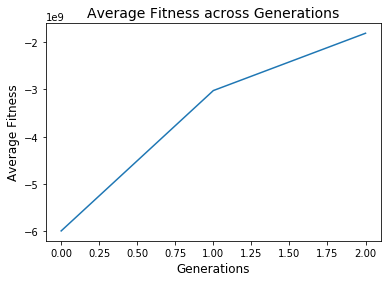

In [7]:
best_chromosome, final_fitness = darwin.train()

In [8]:
final_fitness

-7762020.120691158

In [9]:
best_chromosome

array([-1.66387251e-12,  2.58626586e-01, -6.51734915e+00,  1.40026177e-01,
        4.52597333e-02,  1.70736515e-04, -8.09965758e-05, -2.02254715e-07,
        5.21756150e-08,  4.37184173e-11, -1.10199883e-11])

In [10]:
input()
# to prevent submissions on running all cells

''

In [11]:
status = server.get_errors(TEAM_ID, list(best_chromosome))
status

[17812419.96259091, 7762020.120691158]